In [ ]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from syspy.skims import skims
from quetzal.model import stepmodel
from quetzal.io import excel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Corrects footpaths in the LoS table
## Needs PT LoS table and footpaths

In [2]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../model/'

In [ ]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')

The only kind of all-walk connections between centroids should be direct connections without intermediate stops at PT nodes because these are always connected to access/egress links which have non-footpath properties.

Thus, footpaths already computed in prep2 will be parametrised with census based mean distances.

In [4]:
# Drop walking links that use access-egress links
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type']!='walk']

In [5]:
# Use saved non-motorised paths, if they exist from a previous run
import os.path
if os.path.exists(model_path + 'de_pt_los_walk/'):
    w = stepmodel.read_json(model_path + 'de_pt_los_walk')
    sm.pt_los = sm.pt_los.append(w.pt_los.loc[w.pt_los['route_type']=='walk']).reset_index(drop=True)
    print('Added walking paths from previous run')
    sm.to_json(model_path + 'de_pt_los',
               only_attributes=['pt_los'],
               encoding='utf-8')
    assert manual # break automation

Added walking paths from previous run


In [6]:
sm.pt_los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,path,price,route_type,route_type_disagg,route_types,time,waiting_time
49825,1727,NaN,DEA29,429,14614,480778,"[bus_439914, bus_439915, bus_439916, bus_43991...",NaN,3,DE133,NaN,54.319526,rail_long,NaN,"[bus, rail_long]",19422,2651


## Compute mean distances
Based on census data: mean population-weighted distance from origin centroid to every population cluster in the destination zone

In [4]:
# Load census data: Zensus 2011 - Einwohnerzahl je Hektar
# Copyright: © Statistisches Bundesamt, Wiesbaden 2015
# (im Auftrag der Herausgebergemeinschaft)
# Vervielfältigung und Verbreitung, auch auszugsweise, mit Quellenangabe gestattet
if os.path.isfile(input_path + 'Zensus_2011.geojson'):
    pop = gpd.read_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')
else:
    print('No file with geometries found')
    import shapely.speedups
    pop = pd.read_csv(input_path + 'Zensus_2011.csv', sep=';')
    # Restrict to entries that hold information
    pop = pop.loc[pop['Einwohner']!=-1]
    pop = gpd.GeoDataFrame(pop[['Einwohner']],
                          geometry=gpd.points_from_xy(pop['x_mp_100m'], pop['y_mp_100m']))
    pop.crs = 3035
    pop.to_crs(sm.epsg, inplace=True)
    pop['FID'] = np.nan
    z = stepmodel.read_zip(model_path + 'de_zones.zip')
    shapely.speedups.enable
    for _, zone in tqdm(z.zones.iterrows(), total=z.zones.shape[0]):
        pop.loc[pop['geometry'].within(zone['geometry']), 'FID'] = zone['FID']
    pop.to_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')

In [5]:
pop.sample()

,Einwohner,NUTS_ID,FID,geometry
3122878,32,DEF0B,DEF0B,POINT (9.67815 54.31673)


In [16]:
# Build zone-connecting footpaths
foot = engine.ntlegs_from_centroids_and_nodes(
    ae.centroids,
    ae.centroids,
    short_leg_speed=params['pt_access']['speed_bicycle'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=params['access-egress_links']['n_bicycle_between_zones'],
    coordinates_unit=ae.coordinates_unit)
foot = foot.loc[foot['distance']<=params['access-egress_links']['bicycle_max_dist']]
foot = foot.loc[foot['distance']!=0]
foot.drop_duplicates(['direction', 'distance', 'time'], inplace=True)
print(len(foot))
foot.sample()

2239


,a,b,direction,distance,speed,time,geometry
index,,,,,,,
foot_62055,DE252,DE258,eggress,17708.821875,17.0,3750.103456,"LINESTRING (10.84967 49.44674, 10.97821 49.58237)"


In [17]:
try:
    speed = foot['speed'].mean() # in km/h
except KeyError:
    speed = params['pt_access']['speed_bicycle']
foot = foot[['a', 'b']]
speed

16.908887896382314

In [18]:
# Build all columns of LoS table
foot['index'] = foot.index
foot['path'] = [(a,i,b) for a,i,b in zip(foot['a'], foot.index, foot['b'])]
foot.drop('index', axis=1, inplace=True)
foot = foot.rename(columns={'a': 'origin', 'b': 'destination'})
foot['link_path'] = [[] for _ in range(len(foot))]
for col in ['ntransfers', 'access_time', 'footpath_time',
            'in_vehicle_time', 'waiting_time',
            'boarding_time', 'time', 'length', 'price']:
    if col in sm.pt_los.columns:
        foot[col] = 0
foot['route_types'] = [('walk',) for _ in range(len(foot))]
foot['route_type'] = 'walk'

In [19]:
foot = foot.loc[~(~(foot['origin'].str.startswith('DE')) |
                  ~(foot['origin'].str.startswith('DE')) |
                  (foot['origin']==foot['destination']))]
foot.shape

(2222, 15)

In [20]:
foot.drop_duplicates(subset=['origin', 'destination'], inplace=True)
foot.reset_index(drop=True, inplace=True)

In [24]:
foot.sample()

,origin,destination,path,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,length,price,accessibility,route_types,route_type
2075,DEB1C,DEB11,"(DEB1C, foot_62668, DEB11)",[],0,0,0,0,0,0,0,0,1,"(walk,)",walk


In [32]:
# Calculate mean population-weighted distances
# from the origin centroid to all points in the destination zone
for ind, row in tqdm(foot.iterrows(), total=len(foot.index)):
    o = ae.centroids.loc[row['origin'], 'geometry']
    zone = pop.loc[pop['NUTS_ID']==row['destination']]
    weighted_dist = [skims.get_distance_from_lon_lat_in_m(
        o.coords[0][0], o.coords[0][1], p['geometry'].coords[0][0], p['geometry'].coords[0][1])
                     * p['Einwohner'] for _, p in zone.iterrows()]
    foot.loc[ind, 'length'] = sum(weighted_dist) / zone['Einwohner'].sum()

100%|████████████████████████████████████████████████████████████████████████████| 2222/2222 [1:00:21<00:00,  1.63s/it]


<AxesSubplot:>

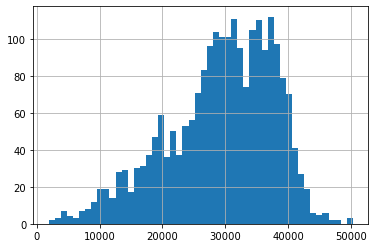

In [33]:
foot['length'].hist(bins=50)

<AxesSubplot:>

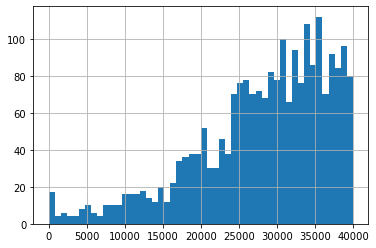

In [35]:
# Compare to quickly approximated distances
ae.footpaths.loc[(ae.footpaths['a'].apply(lambda s: len(s.split('_'))<=2)) &
                 (ae.footpaths['b'].apply(lambda s: len(s.split('_'))<=2)),
                 'distance'].hist(bins=50)

In [36]:
# Replace NaN
foot.loc[foot['length'].isna(), 'length'] = foot.loc[foot['length'].notna(), 'length'].mean()

In [37]:
# Generate time in seconds
foot['time'] = foot['length'] / (speed / 3.6)
if 'footpath_time' in sm.pt_los.columns:
    foot['footpath_time'] = foot['time']

<AxesSubplot:>

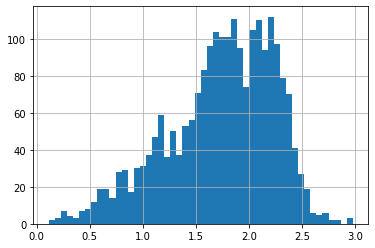

In [39]:
(foot['time']/3600).hist(bins=50) # in h

In [40]:
# Make DataFrame lighter
cols = ['length'] + [col for col in foot.columns if col[-4:]=='time']
foot[cols] = foot[cols].astype(int)

In [41]:
# Add to LoS table
sm.pt_los = sm.pt_los.append(foot).reset_index(drop=True)

In [7]:
sm.pt_los.loc[sm.pt_los['route_type']=='walk'].sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,path,price,route_type,route_type_disagg,route_types,time,waiting_time
718420,0,1.0,DED52,7093,0,33317,[],NaN,0,DED53,"[DED53, foot_60726, DED52]",0.0,walk,walk,[walk],7093,0


## Save

In [8]:
sm.to_json(model_path + 'de_pt_los',
           only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.16it/s]
